# Dual auto-encoder workflow idea for generating invasion probability (idea credit: Niels Billiet)

In [ ]:
# import dependencies

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from captum.attr import IntegratedGradients
from sklearn.metrics import roc_auc_score

print("All dependencies imported successfully.")

All dependencies imported successfully.


# 1. Generate some species and country characteristics data

In [3]:
# ==========================================
# 1. DATA GENERATION (Synthetic Dataset)
# ==========================================
np.random.seed(42)
n_species = 100
n_countries = 50

# Species traits (10 features) with 20% missing values
s_data = np.random.randn(n_species, 10)
mask = np.random.choice([True, False], size=s_data.shape, p=[0.2, 0.8])
s_data[mask] = np.nan

# Country traits (8 features)
c_data = np.random.randn(n_countries, 8)

# Dummy labels for training the predictor
# (In real life, this is your historical record of which species invaded where)
n_train_samples = 500
train_species_idx = np.random.randint(0, n_species, n_train_samples)
train_country_idx = np.random.randint(0, n_countries, n_train_samples)
# Label is 1 if traits align, else 0
y_train = (np.random.rand(n_train_samples) > 0.5).astype(float)

# 2. Pre-process data by filling NAs and scaling data

In [4]:
# ==========================================
# 2. PRE-PROCESSING
# ==========================================
# Fill NaNs with mean and scale
s_mean = np.nanmean(s_data, axis=0)
s_filled = np.where(np.isnan(s_data), s_mean, s_data)

scaler_s = StandardScaler()
scaler_c = StandardScaler()

X_s_tensor = torch.FloatTensor(scaler_s.fit_transform(s_filled))
X_c_tensor = torch.FloatTensor(scaler_c.fit_transform(c_data))
Y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)

# 3. Create the auto-encoder models for both (denoised) species traits and country traits, as well as the invasion probability predictor

In [5]:
# ==========================================
# 3. MODEL ARCHITECTURES
# ==========================================
class DenoisingSpeciesAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 32), nn.ReLU(), nn.Linear(32, latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 32), nn.ReLU(), nn.Linear(32, input_dim))
    def forward(self, x):
        noise = torch.randn_like(x) * 0.1
        z = self.encoder(x + noise)
        return z, self.decoder(z)

class CountryAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 32), nn.ReLU(), nn.Linear(32, latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 32), nn.ReLU(), nn.Linear(32, input_dim))
    def forward(self, x):
        z = self.encoder(x)
        return z, self.decoder(z)

class InvasionPredictor(nn.Module):
    def __init__(self, s_enc, c_enc, s_lat, c_lat):
        super().__init__()
        self.s_enc = s_enc
        self.c_enc = c_enc
        self.classifier = nn.Sequential(
            nn.Linear(s_lat + c_lat, 16), nn.ReLU(),
            nn.Linear(16, 1), nn.Sigmoid()
        )
    def forward(self, s, c):
        return self.classifier(torch.cat((self.s_enc(s), self.c_enc(c)), dim=1))

# 4. Train the models

In [ ]:
# ==========================================
# 4. TRAINING PIPELINE 
# ==========================================

#TO DO: add error VS bias diagnostics here also to verify model training quality
# Important 

LATENT_DIM = 4
spec_ae = DenoisingSpeciesAE(10, LATENT_DIM)
coun_ae = CountryAE(8, LATENT_DIM)

# Step A: Pre-train AEs
def train_ae(model, data):
    opt = optim.Adam(model.parameters(), lr=0.01)
    for _ in range(100):
        z, rec = model(data)
        loss = nn.MSELoss()(rec, data)
        opt.zero_grad(); loss.backward(); opt.step()

train_ae(spec_ae, X_s_tensor)
train_ae(coun_ae, X_c_tensor)

# Step B: Train Predictor
predictor = InvasionPredictor(spec_ae.encoder, coun_ae.encoder, LATENT_DIM, LATENT_DIM)
opt_p = optim.Adam(predictor.parameters(), lr=0.01)

for _ in range(200):
    # Training on a subset of known interactions
    p_out = predictor(X_s_tensor[train_species_idx], X_c_tensor[train_country_idx])
    loss = nn.BCELoss()(p_out, Y_train_tensor)
    opt_p.zero_grad(); loss.backward(); opt_p.step()

# 5. Calculate all risks for all species in all countries


--- GLOBAL INVASION PROBABILITY LIST ---
Species_70    0.998987
Species_3     0.979997
Species_14    0.952237
Species_48    0.928523
Species_73    0.928515
Species_45    0.912009
Species_1     0.906081
Species_86    0.905309
Species_64    0.902157
Species_7     0.895456
Species_98    0.869899
Species_18    0.853848
Species_22    0.839780
Species_90    0.839319
Species_96    0.803381
Species_12    0.797261
Species_24    0.794262
Species_87    0.788510
Species_67    0.783164
Species_89    0.778661
dtype: float64


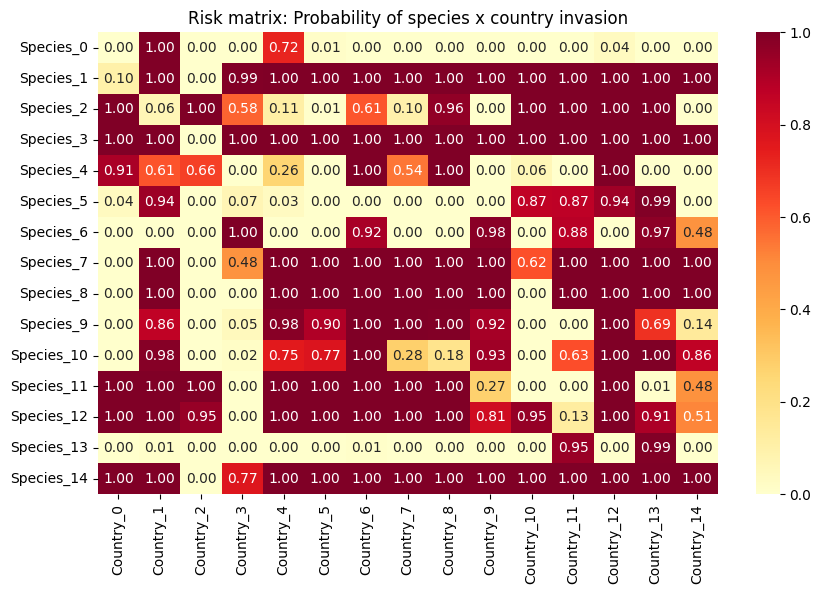

In [10]:
# ==========================================
# 5. FINAL INFERENCE: THE RISK MATRIX 
# ==========================================

#currently on all, also the already invaded species x country pairs

predictor.eval()
with torch.no_grad():
    # Matrix of (N_Species x N_Countries)
    full_risk_matrix = np.zeros((n_species, n_countries))
    for i in range(n_species):
        # Repeat species i traits for all countries
        s_rep = X_s_tensor[i].unsqueeze(0).repeat(n_countries, 1)
        full_risk_matrix[i, :] = predictor(s_rep, X_c_tensor).squeeze().numpy()

# Format as DataFrame
species_names = [f"Species_{i}" for i in range(n_species)]
country_names = [f"Country_{j}" for j in range(n_countries)]
df_risk = pd.DataFrame(full_risk_matrix, index=species_names, columns=country_names)

# Output: Mean probability for all species
print("\n--- GLOBAL INVASION PROBABILITY LIST ---")
species_summary = df_risk.mean(axis=1).sort_values(ascending=False)
print(species_summary.head(20)) # Top 20 most invasive species

# Visualize
plt.figure(figsize=(10, 6))
sns.heatmap(df_risk.iloc[:15, :15], annot=True, fmt=".2f",cmap="YlOrRd")
plt.title("Risk matrix: Probability of species x country invasion")
plt.show()

# 6. Evaluate model performance

In [11]:
# ==========================================
# 5. EVALUATE MODEL PERFORMANCE
# ==========================================

def validate_by_country(X_s, X_c, labels, train_indices, country_names):
    """
    Performs validation by holding out one country at a time.
    """
    unique_countries = np.unique(train_country_idx)
    scores = []

    for country_id in unique_countries:
        # Create masks for 'seen' vs 'unseen' countries
        test_mask = (train_country_idx == country_id)
        train_mask = ~test_mask
        
        # Split data
        # Note: We use the same pre-trained AEs
        predictor_loocv = InvasionPredictor(spec_ae.encoder, coun_ae.encoder, LATENT_DIM, LATENT_DIM)
        optimizer = optim.Adam(predictor_loocv.parameters(), lr=0.01)
        
        # Train on all countries EXCEPT country_id
        for epoch in range(100):
            p_out = predictor_loocv(X_s[train_species_idx[train_mask]], X_c[train_country_idx[train_mask]])
            loss = nn.BCELoss()(p_out, Y_train_tensor[train_mask])
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            
        # Predict on the HELD-OUT country
        predictor_loocv.eval()
        with torch.no_grad():
            test_preds = predictor_loocv(X_s[train_species_idx[test_mask]], X_c[train_country_idx[test_mask]])
            actuals = Y_train_tensor[test_mask]
            
            # AUC is a better metric for invasion than accuracy
            if len(torch.unique(actuals)) > 1: # Need both 0 and 1 to calc AUC
                score = roc_auc_score(actuals.numpy(), test_preds.numpy())
                scores.append(score)
                print(f"Country {country_id} ({country_names[country_id]}) Held-Out AUC: {score:.2f}")

    print(f"\nAverage Cross-Country Generalization (AUC): {np.mean(scores):.2f}")

# Run validation
validate_by_country(X_s_tensor, X_c_tensor, Y_train_tensor, train_country_idx, country_names)

Country 0 (Country_0) Held-Out AUC: 0.81
Country 1 (Country_1) Held-Out AUC: 0.71
Country 2 (Country_2) Held-Out AUC: 0.90
Country 3 (Country_3) Held-Out AUC: 0.83
Country 4 (Country_4) Held-Out AUC: 0.73
Country 5 (Country_5) Held-Out AUC: 0.73
Country 6 (Country_6) Held-Out AUC: 1.00
Country 7 (Country_7) Held-Out AUC: 1.00
Country 8 (Country_8) Held-Out AUC: 0.64
Country 9 (Country_9) Held-Out AUC: 0.72
Country 10 (Country_10) Held-Out AUC: 0.54
Country 11 (Country_11) Held-Out AUC: 0.80
Country 12 (Country_12) Held-Out AUC: 0.96
Country 13 (Country_13) Held-Out AUC: 1.00
Country 14 (Country_14) Held-Out AUC: 0.76
Country 15 (Country_15) Held-Out AUC: 0.88
Country 16 (Country_16) Held-Out AUC: 1.00
Country 17 (Country_17) Held-Out AUC: 0.90
Country 18 (Country_18) Held-Out AUC: 1.00
Country 19 (Country_19) Held-Out AUC: 1.00
Country 20 (Country_20) Held-Out AUC: 1.00
Country 21 (Country_21) Held-Out AUC: 0.96
Country 22 (Country_22) Held-Out AUC: 1.00
Country 24 (Country_24) Held-Ou

# 7. Evaluate importance of different country and species traits for making risk predictions

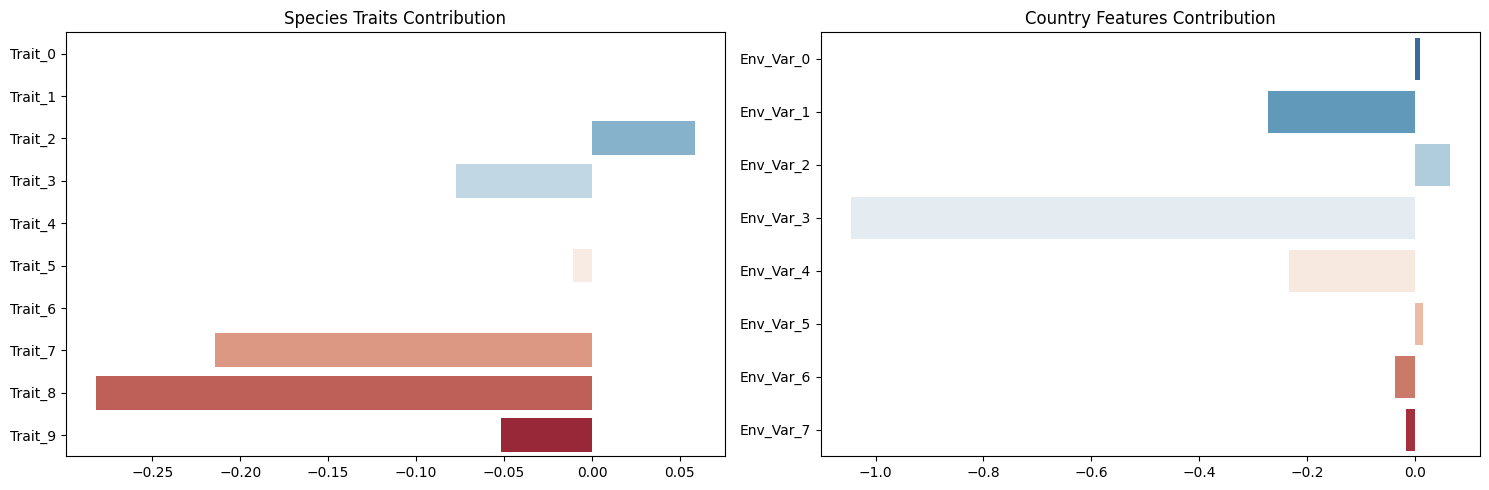

In [ ]:
#Attribution workflow (full model)

def explain_prediction(species_idx, country_idx, predictor, X_s, X_c, s_cols, c_cols):
    predictor.eval()
    
    def model_forward(s_input, c_input):
        return predictor(s_input, c_input)

    ig = IntegratedGradients(model_forward) #seems OK for feauture evaluation!
    s_input = X_s[species_idx].unsqueeze(0)
    c_input = X_c[country_idx].unsqueeze(0)
    
    attr_s, attr_c = ig.attribute((s_input, c_input), target=0)
    
    s_importance = attr_s.squeeze().numpy()
    c_importance = attr_c.squeeze().numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Updated Seaborn syntax to avoid FutureWarnings
    sns.barplot(x=s_importance, y=s_cols, ax=ax1, hue=s_cols, palette="RdBu_r", legend=False)
    ax1.set_title(f"Species Traits Contribution")
    
    sns.barplot(x=c_importance, y=c_cols, ax=ax2, hue=c_cols, palette="RdBu_r", legend=False)
    ax2.set_title(f"Country Features Contribution")
    
    plt.tight_layout()
    plt.show()
    
# Example usage (assuming you have column name lists)
s_feature_names = [f"Trait_{i}" for i in range(10)]
c_feature_names = [f"Env_Var_{i}" for i in range(8)]

# Explain the 1st species in the 1st country
explain_prediction(0, 0, predictor, X_s_tensor, X_c_tensor, s_feature_names, c_feature_names)

# 8. Predict for a new country example (better to retrain the full model set)

In [13]:
# ==========================================
# 8. PREDICT ON NEW DATA (example)
# ==========================================
def predict_invasion_risk(new_species_raw, new_country_raw):
    """
    new_species_raw: np.array of traits (can contain NaNs)
    new_country_raw: np.array of country traits
    """
    predictor.eval()
    with torch.no_grad():
        # 1. Handle Species: Fill NaNs with training mean and scale
        s_filled = np.nan_to_num(new_species_raw, nan=s_mean)
        s_scaled = scaler_s.transform(s_filled.reshape(1, -1))
        s_tensor = torch.FloatTensor(s_scaled)
        
        # 2. Handle Country: Scale the new country data
        c_scaled = scaler_c.transform(new_country_raw.reshape(1, -1))
        c_tensor = torch.FloatTensor(c_scaled)
        
        # 3. Predict
        probability = predictor(s_tensor, c_tensor)
        
    return probability.item()

# Example: Predicting for a new country with random traits
new_country_traits = np.random.randn(8) 
new_species_traits = s_data[0] # Using an existing species

prob = predict_invasion_risk(new_species_traits, new_country_traits)
print(f"Risk for New Country: {prob:.2%}")

Risk for New Country: 100.00%


# 9. Calculate uncertainty on predictions

Pre-training Encoders...
Training Predictor...
Generating Risk & Uncertainty Matrices...


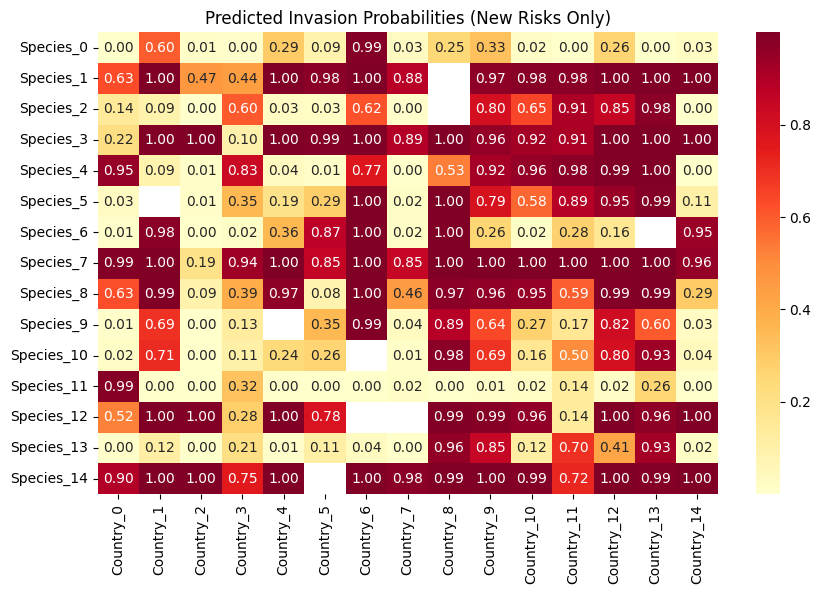

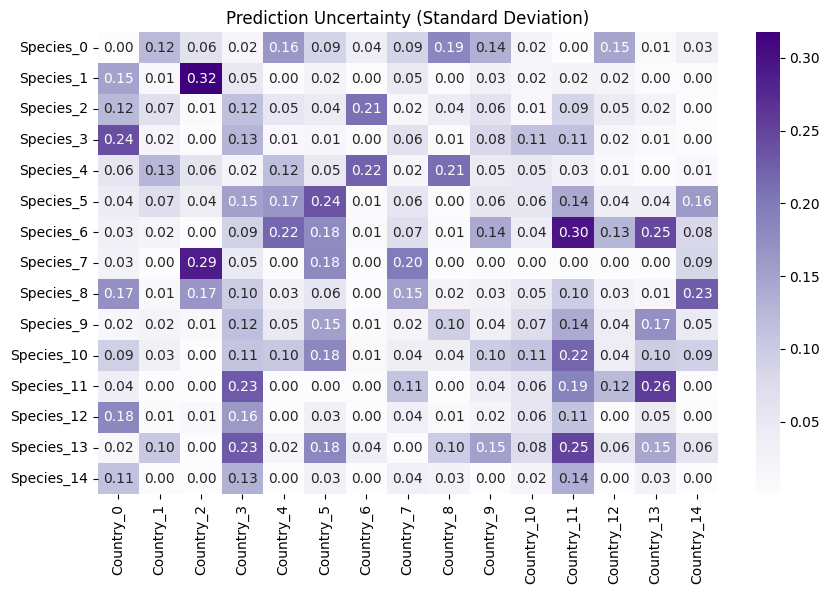

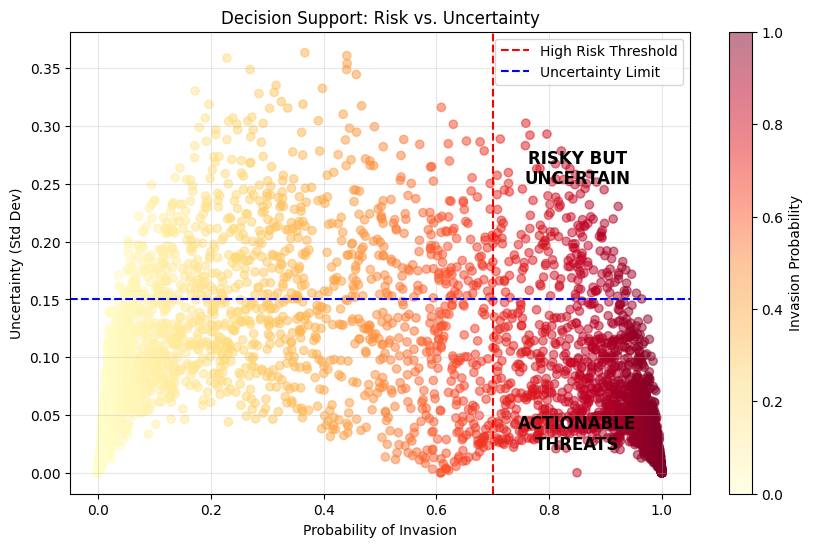


--- WARNING: HIGH NOVELTY SPECIES (POSSIBLY UNRELIABLE) ---
Species_63: Reconstruction Error = 5.2026
Species_56: Reconstruction Error = 5.5605
Species_70: Reconstruction Error = 5.8045
Species_64: Reconstruction Error = 5.9403
Species_3: Reconstruction Error = 6.2345


In [ ]:
# ==========================================
# 1. DATA GENERATION (Synthetic Dataset)
# ==========================================
np.random.seed(42)
torch.manual_seed(42)

n_species = 100
n_countries = 50

# Species traits (10 features) with 20% missing values
s_data = np.random.randn(n_species, 10)
mask = np.random.choice([True, False], size=s_data.shape, p=[0.2, 0.8])
s_data[mask] = np.nan

# Country traits (8 features)
c_data = np.random.randn(n_countries, 8)

# Dummy labels (0 = No Invasion, 1 = Invasion)
# We simulate a "ground truth" where invasion happens if traits align
n_train_samples = 500
train_species_idx = np.random.randint(0, n_species, n_train_samples)
train_country_idx = np.random.randint(0, n_countries, n_train_samples)
y_train = (np.random.rand(n_train_samples) > 0.5).astype(float)

# Create a binary matrix of "Existing Invasions" for masking later
# (In real life, you build this from your actual occurrence database)
existing_invasions = np.zeros((n_species, n_countries))
for s, c, y in zip(train_species_idx, train_country_idx, y_train):
    if y == 1.0: existing_invasions[s, c] = 1.0

# ==========================================
# 2. PRE-PROCESSING
# ==========================================
# Fill NaNs with mean and scale
s_mean = np.nanmean(s_data, axis=0)
s_filled = np.where(np.isnan(s_data), s_mean, s_data)

scaler_s = StandardScaler()
scaler_c = StandardScaler()

X_s_tensor = torch.FloatTensor(scaler_s.fit_transform(s_filled))
X_c_tensor = torch.FloatTensor(scaler_c.fit_transform(c_data))
Y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)

# ==========================================
# 3. MODEL ARCHITECTURES
# ==========================================
class DenoisingSpeciesAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        # Dropout here acts as the "noise" for both training AND uncertainty estimation
        self.dropout = nn.Dropout(p=0.1) 
        self.encoder = nn.Sequential(nn.Linear(input_dim, 32), nn.ReLU(), nn.Linear(32, latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 32), nn.ReLU(), nn.Linear(32, input_dim))
        
    def forward(self, x):
        # We apply dropout to input to simulate missingness/noise
        noisy_x = self.dropout(x)
        z = self.encoder(noisy_x)
        return z, self.decoder(z)

class CountryAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 32), nn.ReLU(), nn.Linear(32, latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 32), nn.ReLU(), nn.Linear(32, input_dim))
    def forward(self, x):
        z = self.encoder(x)
        return z, self.decoder(z)

class InvasionPredictor(nn.Module):
    def __init__(self, s_enc, c_enc, s_lat, c_lat):
        super().__init__()
        self.s_enc = s_enc
        self.c_enc = c_enc
        # Dropout in the classifier adds another layer of uncertainty estimation
        self.dropout = nn.Dropout(p=0.1)
        self.classifier = nn.Sequential(
            nn.Linear(s_lat + c_lat, 16),
            nn.ReLU(),
            self.dropout, 
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, s, c):
        # Pass through encoders -> Concatenate -> Classify
        z_s = self.s_enc(s)
        z_c = self.c_enc(c)
        return self.classifier(torch.cat((z_s, z_c), dim=1))

# ==========================================
# 4. TRAINING
# ==========================================
LATENT_DIM = 4
spec_ae = DenoisingSpeciesAE(10, LATENT_DIM)
coun_ae = CountryAE(8, LATENT_DIM)
predictor = InvasionPredictor(spec_ae.encoder, coun_ae.encoder, LATENT_DIM, LATENT_DIM)

# A. Pre-train Autoencoders
print("Pre-training Encoders...")
opt_ae = optim.Adam(list(spec_ae.parameters()) + list(coun_ae.parameters()), lr=0.01)
for _ in range(100):
    _, s_rec = spec_ae(X_s_tensor)
    _, c_rec = coun_ae(X_c_tensor)
    loss = nn.MSELoss()(s_rec, X_s_tensor) + nn.MSELoss()(c_rec, X_c_tensor)
    opt_ae.zero_grad(); loss.backward(); opt_ae.step()

# B. Train Predictor
print("Training Predictor...")
opt_p = optim.Adam(predictor.parameters(), lr=0.01)
predictor.train() # Ensure dropout is ON during training
for _ in range(200):
    p_out = predictor(X_s_tensor[train_species_idx], X_c_tensor[train_country_idx])
    loss = nn.BCELoss()(p_out, Y_train_tensor)
    opt_p.zero_grad(); loss.backward(); opt_p.step()

# ==========================================
# 5. UNCERTAINTY QUANTIFICATION FUNCTIONS
# ==========================================

def calculate_reconstruction_error(species_tensor):
    """Calculates how 'weird' or novel a species is compared to training data."""
    spec_ae.eval() # No dropout for this check
    with torch.no_grad():
        _, rec = spec_ae(species_tensor)
        # Mean Squared Error per sample
        mse = torch.mean((species_tensor - rec)**2, dim=1)
    return mse.numpy()

def predict_with_mc_dropout(s_tensor, c_tensor, n_iter=50):
    """Runs prediction multiple times with Dropout enabled to estimate uncertainty."""
    # Turn ON dropout layers to simulate variance
    spec_ae.train()
    predictor.train() 
    
    probs_list = []
    with torch.no_grad():
        for _ in range(n_iter):
            probs = predictor(s_tensor, c_tensor)
            probs_list.append(probs.squeeze().numpy())
    
    probs_array = np.array(probs_list) # Shape: (n_iter, n_samples)
    
    # Calculate Mean Probability and Standard Deviation (Uncertainty)
    mean_probs = np.mean(probs_array, axis=0)
    uncertainty = np.std(probs_array, axis=0)
    
    return mean_probs, uncertainty

# ==========================================
# 6. FINAL INFERENCE & MASKING
# ==========================================
print("Generating Risk & Uncertainty Matrices...")

# Prepare arrays
risk_matrix = np.zeros((n_species, n_countries))
uncertainty_matrix = np.zeros((n_species, n_countries))

# Iterate through species to fill matrices
# (We do this row-by-row to keep memory usage manageable)
for i in range(n_species):
    # Prepare input batch: Species i vs. ALL Countries
    s_batch = X_s_tensor[i].unsqueeze(0).repeat(n_countries, 1)
    c_batch = X_c_tensor
    
    # Run MC Dropout Prediction
    means, stds = predict_with_mc_dropout(s_batch, c_batch, n_iter=50)
    
    risk_matrix[i, :] = means
    uncertainty_matrix[i, :] = stds

# Convert to DataFrames
species_names = [f"Species_{i}" for i in range(n_species)]
country_names = [f"Country_{j}" for j in range(n_countries)]

df_risk = pd.DataFrame(risk_matrix, index=species_names, columns=country_names)
df_uncert = pd.DataFrame(uncertainty_matrix, index=species_names, columns=country_names)

# MASKING: Remove known invasions
mask_df = pd.DataFrame(existing_invasions, index=species_names, columns=country_names)
df_risk_masked = df_risk.copy()
df_risk_masked[mask_df == 1.0] = np.nan

# ==========================================
# 7. RESULTS & VISUALIZATION
# ==========================================

# A. Heatmap of Risk (New Invasions Only)
plt.figure(figsize=(10, 6))
sns.heatmap(df_risk_masked.iloc[:15, :15], annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Predicted Invasion Probabilities (New Risks Only)")
plt.show()

# B. Heatmap of Uncertainty
plt.figure(figsize=(10, 6))
sns.heatmap(df_uncert.iloc[:15, :15], annot=True, fmt=".2f", cmap="Purples")
plt.title("Prediction Uncertainty (Standard Deviation)")
plt.show()

# C. Actionable Plot: Risk vs. Uncertainty
# Flatten the masked matrix to plot individual pairs
risk_values = df_risk_masked.values.flatten()
uncert_values = df_uncert.values.flatten()

# Remove NaNs (which were the existing invasions)
valid_mask = ~np.isnan(risk_values)
r_clean = risk_values[valid_mask]
u_clean = uncert_values[valid_mask]

# Create Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(r_clean, u_clean, alpha=0.5, c=r_clean, cmap="YlOrRd")
plt.colorbar(label="Invasion Probability")
plt.axvline(x=0.7, color='red', linestyle='--', label="High Risk Threshold")
plt.axhline(y=0.15, color='blue', linestyle='--', label="Uncertainty Limit")

plt.text(0.85, 0.02, "ACTIONABLE\nTHREATS", fontsize=12, color='black', ha='center',weight='bold')
plt.text(0.85, 0.25, "RISKY BUT\nUNCERTAIN", fontsize=12, color='black', ha='center',weight='bold')

plt.title("Decision Support: Risk vs. Uncertainty")
plt.xlabel("Probability of Invasion")
plt.ylabel("Uncertainty (Std Dev)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# D. Reconstruction Novelty Check
# Let's see if any species are outliers
rec_errors = calculate_reconstruction_error(X_s_tensor)
top_novelty_idx = np.argsort(rec_errors)[-5:] # Top 5 weirdest species
print("\n--- WARNING: HIGH NOVELTY SPECIES (POSSIBLY UNRELIABLE) ---")
for idx in top_novelty_idx:
    print(f"Species_{idx}: Reconstruction Error = {rec_errors[idx]:.4f}")